In [56]:
import numpy as np
import rasterio 
import os
import glob

import hmm

In [55]:
def read_file(file):
    with rasterio.open(file) as src:
        return(src.read(1))

In [3]:
root_dir = r'E:\acocac\research\fc2\eval\pred\2_inputs\ep5\bands\convgru64_02_fold0_19713'

In [69]:
file_list = glob.glob(os.path.join(root_dir,'*/confidences/**/*.tif'))
file_list = sorted(file_list, key=lambda x: int(os.path.basename(os.path.dirname(x)).partition('_')[0]))

In [64]:
i = 505

# Read all data as a list of numpy arrays 
pred_list = glob.glob(os.path.join(root_dir,'*/prediction/*.tif'))

pred_files = [read_file(x) for x in pred_list]
pred_files = [x.flatten()[i] for x in pred_files]

print(pred_files)

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 13.0, 9.0, 9.0, 9.0, 2.0]


In [90]:
# Read all data as a list of numpy arrays 
array_list = [read_file(x) for x in file_list]
array_list = [x.flatten()[i] for x in array_list]

In [91]:
t = np.reshape(array_list, (17,14))
z = np.transpose(t,[1,0])
probs = z.flatten()
probs = np.insert(probs,0,0)

In [93]:
print(probs.shape)

(239,)


In [81]:
np.set_printoptions(precision=3, linewidth=1000)

n_labels = 17
change_prob = 0.1
transition_matrix = np.empty((n_labels, n_labels))
transition_matrix.fill(change_prob)
np.fill_diagonal(transition_matrix, 1.0 - change_prob)
print(transition_matrix.shape)
labels = hmm.forward_backward_mle(probs, n_labels, transition_matrix)
print(labels)

(17, 17)
[2 2 2 2 2 2 2 2 2 9 9 9 9 9]


In [136]:
def trans(x):
#     probs = x.flatten()
    probs = x
    probs = np.insert(probs,0,0)

    n_labels = 17
    change_prob = 0.1
    transition_matrix = np.empty((n_labels, n_labels))
    transition_matrix.fill(change_prob)
    np.fill_diagonal(transition_matrix, 1.0 - change_prob)

    labels = hmm.viterbi(probs, n_labels, transition_matrix)
    del transition_matrix
    return(labels)

In [54]:
file_list = glob.glob(os.path.join(root_dir,'*/confidences/**/*.tif'))
file_list = sorted(file_list, key=lambda x: int(os.path.basename(os.path.dirname(x)).partition('_')[0]))

array_list = [read_file(x) for x in file_list]
a = np.stack(array_list)

t = np.reshape(a, (17,14,384*384))
z = np.transpose(t,[1,0,2])
y = np.reshape(z, (14*17,384*384))

NameError: name 'root_dir' is not defined

In [138]:
a = np.apply_along_axis(trans, 0, y)

In [140]:
post_files = np.reshape(a,(a.shape[0],384,384))

In [145]:
changes = np.zeros([13,384,384])

for i in range(len(post_files)-1):
    listarra = [post_files[i],post_files[i+1]]
    a = np.std(listarra, axis=0)
    changes[i][a>0] = 1

In [146]:
change_period = changes.sum(axis=0)

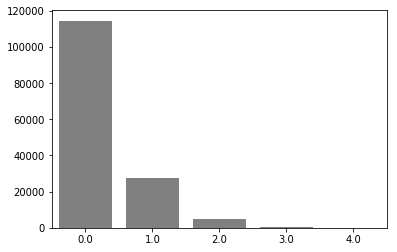

In [147]:
import pandas as pd
import seaborn

df = pd.Series(change_period.flatten())

seaborn.barplot(x=df.value_counts().index, y=df.value_counts(), color='gray')

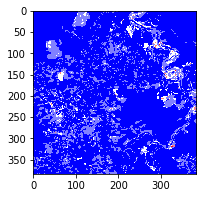

In [149]:
import matplotlib 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3,3))

ax.imshow(change_period, cmap=plt.cm.bwr, interpolation='none') 

In [153]:
with rasterio.open(file_list[0]) as src:
    meta = src.meta

meta.update(dtype=rasterio.int32)

outdir = r'E:\acocac\research\fc2\post'
# Write output file
with rasterio.open(os.path.join(outdir,'changes_post.tif'), 'w', **meta) as dst:
    dst.write(change_period.astype(rasterio.int32), 1)

In [57]:
class classes:
    classes = ['Evergreen needleleaf forest', 'Evergreen broadleaf forest',
               'Deciduous needleleaf forest', 'Deciduous broadleaf forest',
               'Mixed forest', 'Closed shrublands', 'Open shrublands',
               'Woody savannas', 'Savannas', 'Grasslands', 'Permanent wetlands',
               'Croplands', 'Urban and built-up', 'Cropland natural vegetation mosaic',
               'Snow and ice', 'Barren or sparsely vegetated', 'Water']

    colors = ['#05450a', '#086a10',
              '#54a708',
              '#78d203',
              '#009900',
              '#c6b044',
              '#dcd159',
              '#dade48',
              '#fbff13',
              '#b6ff05',
              '#27ff87',
              '#c24f44',
              '#a5a5a5',
              '#ff6d4c',
              '#69fff8',
              '#f9ffa4',
              '#1c0dff']

In [229]:
colormap = matplotlib.colors.LinearSegmentedColormap.from_list(range(17),colors)

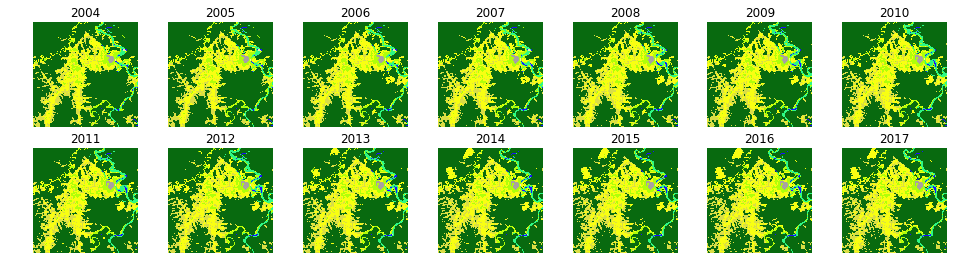

In [275]:
gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.2, hspace=0.2)

fig, axes = plt.subplots(nrows=2, ncols=7, sharex=False, sharey=False, figsize=(16, 4), gridspec_kw=gridspec_kwargs)
axes[-1, -1].axis('off')
axes[-1, -2].axis('off')

axs = axes.flatten()
  
for i, data in enumerate(post_files):
    axs[i].set_title(str(i+2004), fontsize='large')
    axs[i].imshow(data-1, cmap=colormap, interpolation='none', vmin=0, vmax=16) 
    axs[i].axis('off')

In [273]:
#PRED
pred_list = glob.glob(os.path.join(root_dir,'*/prediction/*.tif'))

pred_files = [read_file(x) for x in pred_list]

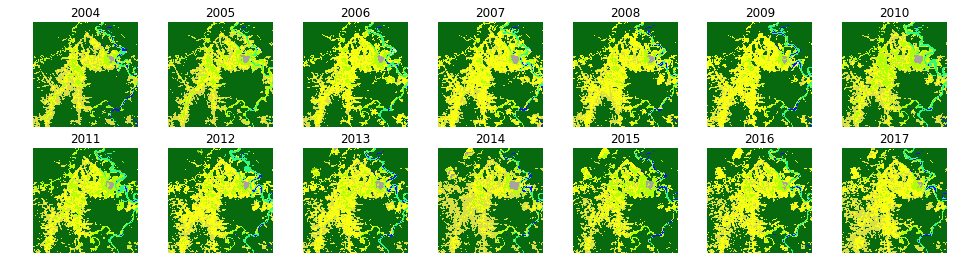

In [274]:
gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.2, hspace=0.2)

fig, axes = plt.subplots(nrows=2, ncols=7, sharex=False, sharey=False, figsize=(16, 4), gridspec_kw=gridspec_kwargs)
axes[-1, -1].axis('off')
axes[-1, -2].axis('off')

axs = axes.flatten()
  
for i, data in enumerate(pred_files):
    axs[i].set_title(str(i+2004), fontsize='large')
    axs[i].imshow(data-1, cmap=colormap, interpolation='none', vmin=0, vmax=16) 
    axs[i].axis('off')

In [257]:
#GT
gt_list = glob.glob(os.path.join(root_dir,'*/ground_truth/*.tif'))

gt_files = [read_file(x) for x in gt_list]

In [249]:
colors_gt = np.insert(colors,0,'#000000')

colormap_gt = matplotlib.colors.LinearSegmentedColormap.from_list(range(18),colors_gt)

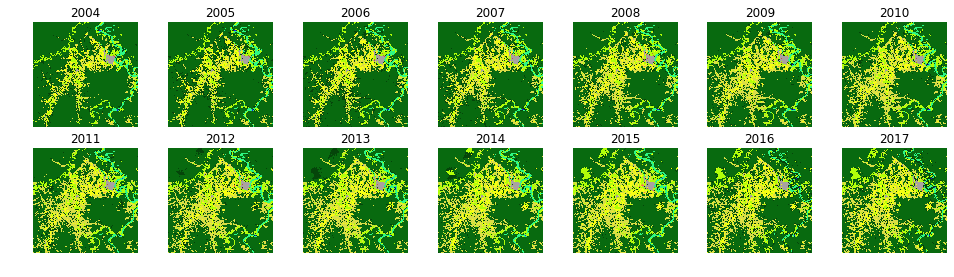

In [272]:
gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.2, hspace=0.2)

fig, axes = plt.subplots(nrows=2, ncols=7, sharex=False, sharey=False, figsize=(16, 4), gridspec_kw=gridspec_kwargs)
axes[-1, -1].axis('off')
axes[-1, -2].axis('off')

axs = axes.flatten()
  
for i, data in enumerate(gt_files):
    axs[i].set_title(str(i+2004), fontsize='large')
    axs[i].imshow(data-1, cmap=colormap, interpolation='none', vmin=0, vmax=16) 
    axs[i].axis('off')

## GT raw 500m

In [39]:
fn = r'E:\acocac\research\fc2\basemap\MCD12Q1v6raw_originalwgs84.tif'

In [43]:
from osgeo import gdal
import matplotlib 
import matplotlib.pyplot as plt

inRas = gdal.Open(fn)
gt_data = inRas.ReadAsArray()
gt_data = gt_data[3:,:,:]

In [44]:
colormap = matplotlib.colors.LinearSegmentedColormap.from_list(range(17),colors)

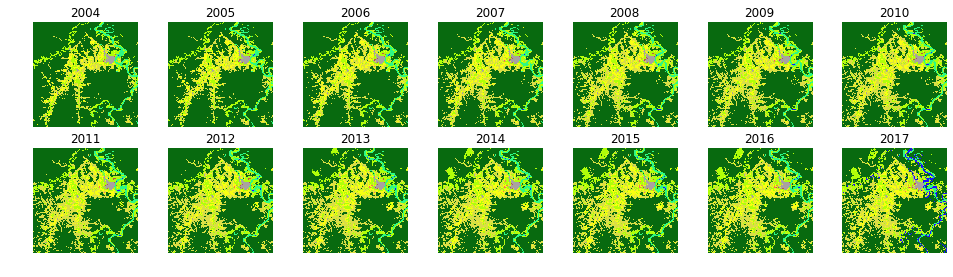

In [45]:
gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.2, hspace=0.2)

fig, axes = plt.subplots(nrows=2, ncols=7, sharex=False, sharey=False, figsize=(16, 4), gridspec_kw=gridspec_kwargs)
axes[-1, -1].axis('off')
axes[-1, -2].axis('off')

axs = axes.flatten()
  
for i, data in enumerate(gt_data):
    axs[i].set_title(str(i+2004), fontsize='large')
    axs[i].imshow(data-1, cmap=colormap, interpolation='none', vmin=0, vmax=16) 
    axs[i].axis('off')

In [50]:
changes = np.zeros([13,194,193])

for i in range(len(gt_data)-1):
    listarra = [gt_data[i],gt_data[i+1]]
    a = np.std(listarra, axis=0)
    changes[i][a>0] = 1

In [51]:
change_period = changes.sum(axis=0)

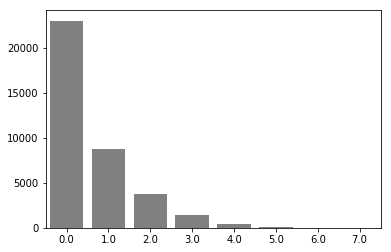

In [52]:
import pandas as pd
import seaborn

df = pd.Series(change_period.flatten())

seaborn.barplot(x=df.value_counts().index, y=df.value_counts(), color='gray')

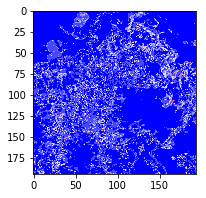

In [53]:
import matplotlib 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3,3))

ax.imshow(change_period, cmap=plt.cm.bwr, interpolation='none') 

## GT raw terra

In [30]:
fn = r'E:\acocac\research\fc2\basemap\MCD12Q1v6raw_terra.tif'

In [31]:
from osgeo import gdal
import matplotlib 
import matplotlib.pyplot as plt

inRas = gdal.Open(fn)
gt_data = inRas.ReadAsArray()
gt_data = gt_data[3:,:,:]

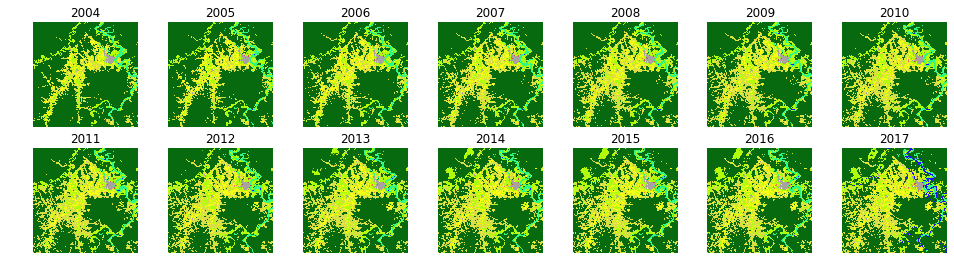

In [32]:
colormap = matplotlib.colors.LinearSegmentedColormap.from_list(range(17),colors)

gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.2, hspace=0.2)

fig, axes = plt.subplots(nrows=2, ncols=7, sharex=False, sharey=False, figsize=(16, 4), gridspec_kw=gridspec_kwargs)
axes[-1, -1].axis('off')
axes[-1, -2].axis('off')

axs = axes.flatten()
  
for i, data in enumerate(gt_data):
    axs[i].set_title(str(i+2004), fontsize='large')
    axs[i].imshow(data-1, cmap=colormap, interpolation='none', vmin=0, vmax=16) 
    axs[i].axis('off')

In [33]:
len(gt_data)

14

In [35]:
changes = np.zeros([13,386,386])

for i in range(len(gt_data)-1):
    listarra = [gt_data[i],gt_data[i+1]]
    a = np.std(listarra, axis=0)
    changes[i][a>0] = 1

In [36]:
change_period = changes.sum(axis=0)

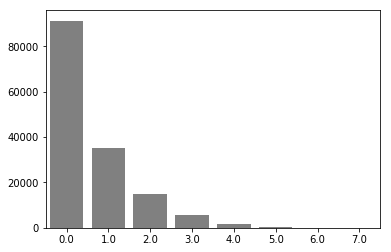

In [37]:
import pandas as pd
import seaborn

df = pd.Series(change_period.flatten())

seaborn.barplot(x=df.value_counts().index, y=df.value_counts(), color='gray')

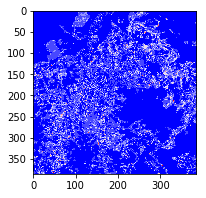

In [38]:
import matplotlib 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3,3))

ax.imshow(change_period, cmap=plt.cm.bwr, interpolation='none') 